In [100]:
import pandas as pd
import math as math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('./merged-daily-sales.csv')
unique_product_names = df['Produk'].unique()

'''
Produk Name in Column
['PicsArt PRO' 'Bstation' 'WeTV VIP' 'VIU Premium' 'Prime Video' 'HBO GO'
 'IQIYI VIP' 'Youku' 'Vidio Premier' 'Netflix Premium' 'Disney+ Hostar'
 'Youtube Premium' 'Catchplay+' 'Mango TV' 'Vision+ Sport' 'Apple TV+'
 'VN Pro' 'NordVPN' 'Apple Music' nan 'Capcut Pro' 'Iflix' 'Viki Rakuten'
 'Genflix' 'Microsoft 360' 'Canva PRO' 'Remini Pro' 'Spotify Premium'
 'Mojo Pro' 'Lightroom' 'Mola TV' 'Loklok' 'Gramedia Digital' '1 Tahun'
 'Tiktok Music' 'Vision Sport' 'wtsa' 'Gagaoolala' 'q' 'HBO MAX' 
 'Youku VIP' 'ChatGPT' '1']
'''

product_names = [
 'PicsArt PRO', 'Bstation', 'WeTV VIP', 'VIU Premium', 'Prime Video', 'HBO GO',
 'IQIYI VIP', 'Youku', 'Vidio Premier', 'Netflix Premium', 'Disney+ Hostar',
 'Youtube Premium', 'Catchplay+', 'Mango TV', 'Vision+ Sport', 'Apple TV+',
 'VN Pro', 'NordVPN', 'Apple Music', 'Capcut Pro', 'Iflix', 'Viki Rakuten',
 'Genflix', 'Microsoft 360', 'Canva PRO', 'Remini Pro', 'Spotify Premium',
 'Mojo Pro', 'Lightroom', 'Mola TV', 'Loklok', 'Gramedia Digital', 'Tiktok Music', 
 'Vision Sport', 'Gagaoolala', 'HBO MAX', 'Youku VIP', 'ChatGPT'
]


# Filter out rows in 'Produk' column
product_items = [ 'VIU Premium', 'IQIYI VIP', 'Vidio Premier', 'Bstation',]

df  = df[df['Produk'].isin(product_items)]

Summarized Missing Data : Tanggal    1
Produk     0
Harga      1
dtype: int64
Deleted Data:2


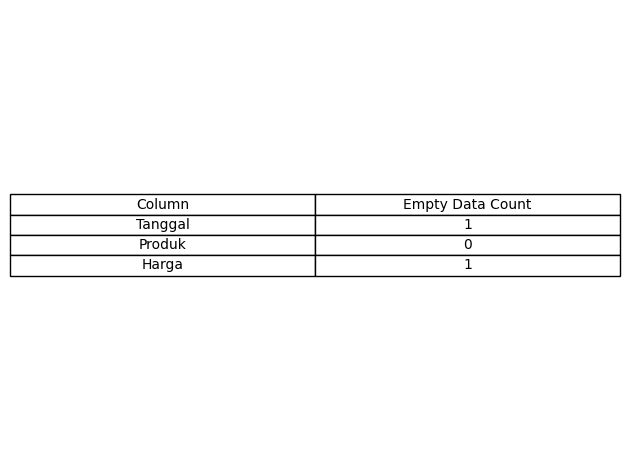

In [101]:
#Check Missing Data
def dropna_columns():
    global df
    null_data = pd.DataFrame({
        "Column": df.columns,
        "Empty Data Count": df.isnull().sum().values
    })
    print(f"Summarized Missing Data : {df.isnull().sum()}")


    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')


    ax.table(cellText=null_data.values, colLabels=null_data.columns, loc='center',cellLoc='center')

    fig.tight_layout()

    initial_rows = len(df)

    df = df.dropna()

    # df.to_csv('no_missing_data.csv', index=False)

    print(f"Deleted Data:{initial_rows - len(df)}")
    
dropna_columns()

In [102]:
# --- 2. Data Preprocessing ---
# Convert 'Tanggal' to datetime objects
# This is crucial for correct chronological sorting and time-based operations.
# We use dayfirst=True if your date format is DD-MM-YYYY. Adjust if it's MM-DD-YYYY.
try:
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True)
except ValueError:
    print("Attempting to parse Tanggal with default format (MM-DD-YYYY or YYYY-MM-DD).")
    df['Tanggal'] = pd.to_datetime(df['Tanggal'])
    
# Ensure 'Harga' is a numeric type
df['Harga'] = pd.to_numeric(df['Harga'], errors='coerce') # 'coerce' will turn non-numeric into NaN

# Data Aggregation

In [103]:
df = df.groupby(['Tanggal', 'Produk']).agg(
    total_revenue=('Harga', 'sum'),
    # transaction_count=('Harga', 'count'),
    # average_price=('Harga', 'mean')
).reset_index()
df = df.sort_values(by=['Produk', 'Tanggal']).reset_index(drop=True)
# df.to_csv('processed_sales_data.csv', index=False)

# Time Feature Engineering

In [104]:
# df['month'] = df['Tanggal'].dt.month
# df['day'] = df['Tanggal'].dt.day
# df['day_of_week'] = df['Tanggal'].dt.dayofweek

# df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
# df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# # DayOfWeek
# df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
# df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int) 


# Rolling Statistics

In [105]:
window_sizes = [7,14]
target_col = 'total_revenue'

for window in window_sizes:
    grouped_product_data = df.groupby('Produk')[target_col]

    df[f'{target_col}_ema_{window}'] = grouped_product_data.shift(1).ewm(span=window, adjust=False, min_periods=1).mean()

    df[f'{target_col}_roll_std_{window}'] = grouped_product_data.transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
    )
    df[f'{target_col}_roll_min_{window}'] = grouped_product_data.transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).min()
    )
    df[f'{target_col}_roll_max_{window}'] = grouped_product_data.transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).max()
    )

# Lag

In [106]:
lag_periods = [1,7,14] # Define specific lags you want

for lag in lag_periods:
    df[f'{target_col}_lag_{lag}'] = df.groupby('Produk')[target_col].shift(lag)

# Create Specific Target Variable For 1 Month Ahead

In [107]:
# forecast_horizon_days = 30
# df['target_revenue_1_month_ahead'] = df.groupby('Produk')[target_col].shift(-forecast_horizon_days)

# Remove NaN Data To Ensure Data Cleanliness

Summarized Missing Data : Tanggal                       0
Produk                        0
total_revenue                 0
total_revenue_ema_7           1
total_revenue_roll_std_7      8
total_revenue_roll_min_7      4
total_revenue_roll_max_7      4
total_revenue_ema_14          1
total_revenue_roll_std_14     8
total_revenue_roll_min_14     4
total_revenue_roll_max_14     4
total_revenue_lag_1           4
total_revenue_lag_7          28
total_revenue_lag_14         56
dtype: int64
Deleted Data:56


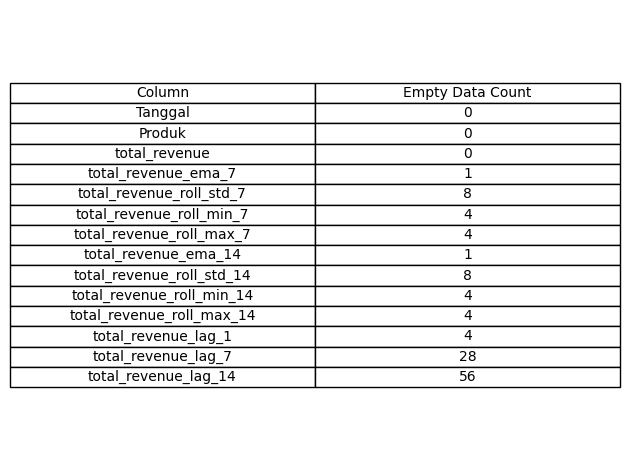

In [108]:


# df = df.dropna(subset=['target_price_1_month_ahead'])
dropna_columns()

# Encode Product

In [109]:
# le = LabelEncoder()
# df['produk_encoded'] = le.fit_transform(df['Produk'])

# Split The Data

In [110]:
start_date = pd.to_datetime('2025-01-01')

df.to_csv("final_dataset.csv", index=False)

# data_feb_apr_2025 = df[
#     (df['Tanggal'] >= start_date)
# ]

# df = df[
#   (df['Tanggal'] < start_date)
# ]

# print(f"Jumlah Data Feb-Apr 2025: {len(data_feb_apr_2025)}")
# print(f"Jumlah Data Jan 2024 - Jan 2025: {len(df)}")

# data_feb_apr_2025.to_csv('data_test.csv', index=False)
# df.to_csv('data_training.csv', index=False)

print(df.columns)


Index(['Tanggal', 'Produk', 'total_revenue', 'total_revenue_ema_7',
       'total_revenue_roll_std_7', 'total_revenue_roll_min_7',
       'total_revenue_roll_max_7', 'total_revenue_ema_14',
       'total_revenue_roll_std_14', 'total_revenue_roll_min_14',
       'total_revenue_roll_max_14', 'total_revenue_lag_1',
       'total_revenue_lag_7', 'total_revenue_lag_14'],
      dtype='object')
